In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

## Fazendo Ajustes Polinomiais para remoção de ruido

In [3]:
path = 'SRAG_time_series/SRAG_TS_weekly.csv'

df = pd.read_csv(path, sep=",", encoding="latin-1")
df["Year_Week"] = pd.to_datetime(df['Year_Week'], format='%Y-%m-%d')
df = df.iloc[1:].reset_index(drop=True)
df

,Year_Week,Number_Cases,week
0,2019-01-07,256.0,2
1,2019-01-14,270.0,3
2,2019-01-21,273.0,4
3,2019-01-28,282.0,5
4,2019-02-04,300.0,6
...,...,...,...
312,2024-12-02,4298.0,49
313,2024-12-09,4284.0,50
314,2024-12-16,4028.0,51
315,2024-12-23,4028.0,52


   Year_Week  Number_Cases  Log_Number_Cases
0 2019-01-07         256.0          5.549076
1 2019-01-14         270.0          5.602119
2 2019-01-21         273.0          5.613128
3 2019-01-28         282.0          5.645447
4 2019-02-04         300.0          5.707110


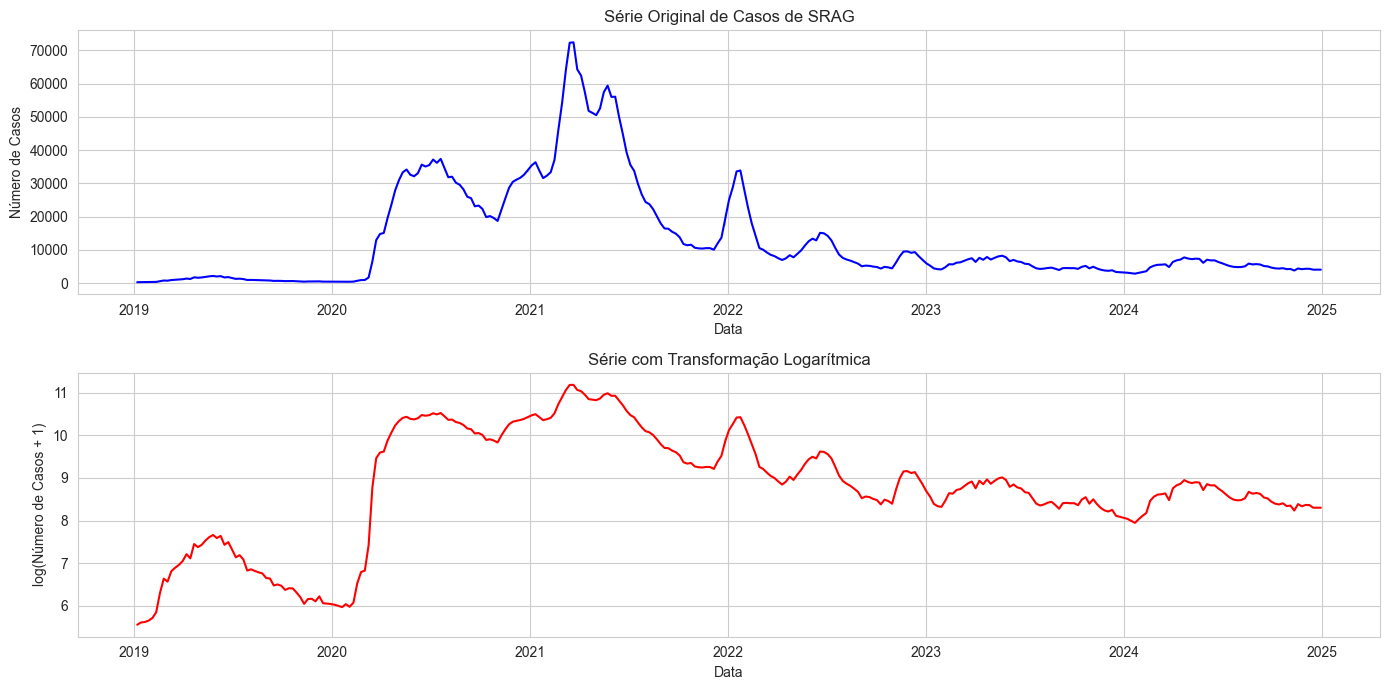

In [13]:
# Aplicar transformação logarítmica
df['Log_Number_Cases'] = np.log(df['Number_Cases'] + 1)  # Adicionamos 1 para evitar log(0)

# Visualizar as primeiras linhas para verificar a transformação
print(df[['Year_Week', 'Number_Cases', 'Log_Number_Cases']].head())

# Plotar a série original e a transformada
plt.figure(figsize=(14, 7))

# Gráfico da série original
plt.subplot(2, 1, 1)
sns.lineplot(data=df, x='Year_Week', y='Number_Cases', color='blue')
plt.title('Série Original de Casos de SRAG')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.grid(True)

# Gráfico da série com transformação logarítmica
plt.subplot(2, 1, 2)
sns.lineplot(data=df, x='Year_Week', y='Log_Number_Cases', color='red')
plt.title('Série com Transformação Logarítmica')
plt.xlabel('Data')
plt.ylabel('log(Número de Casos + 1)')
plt.grid(True)

plt.tight_layout()
plt.show()

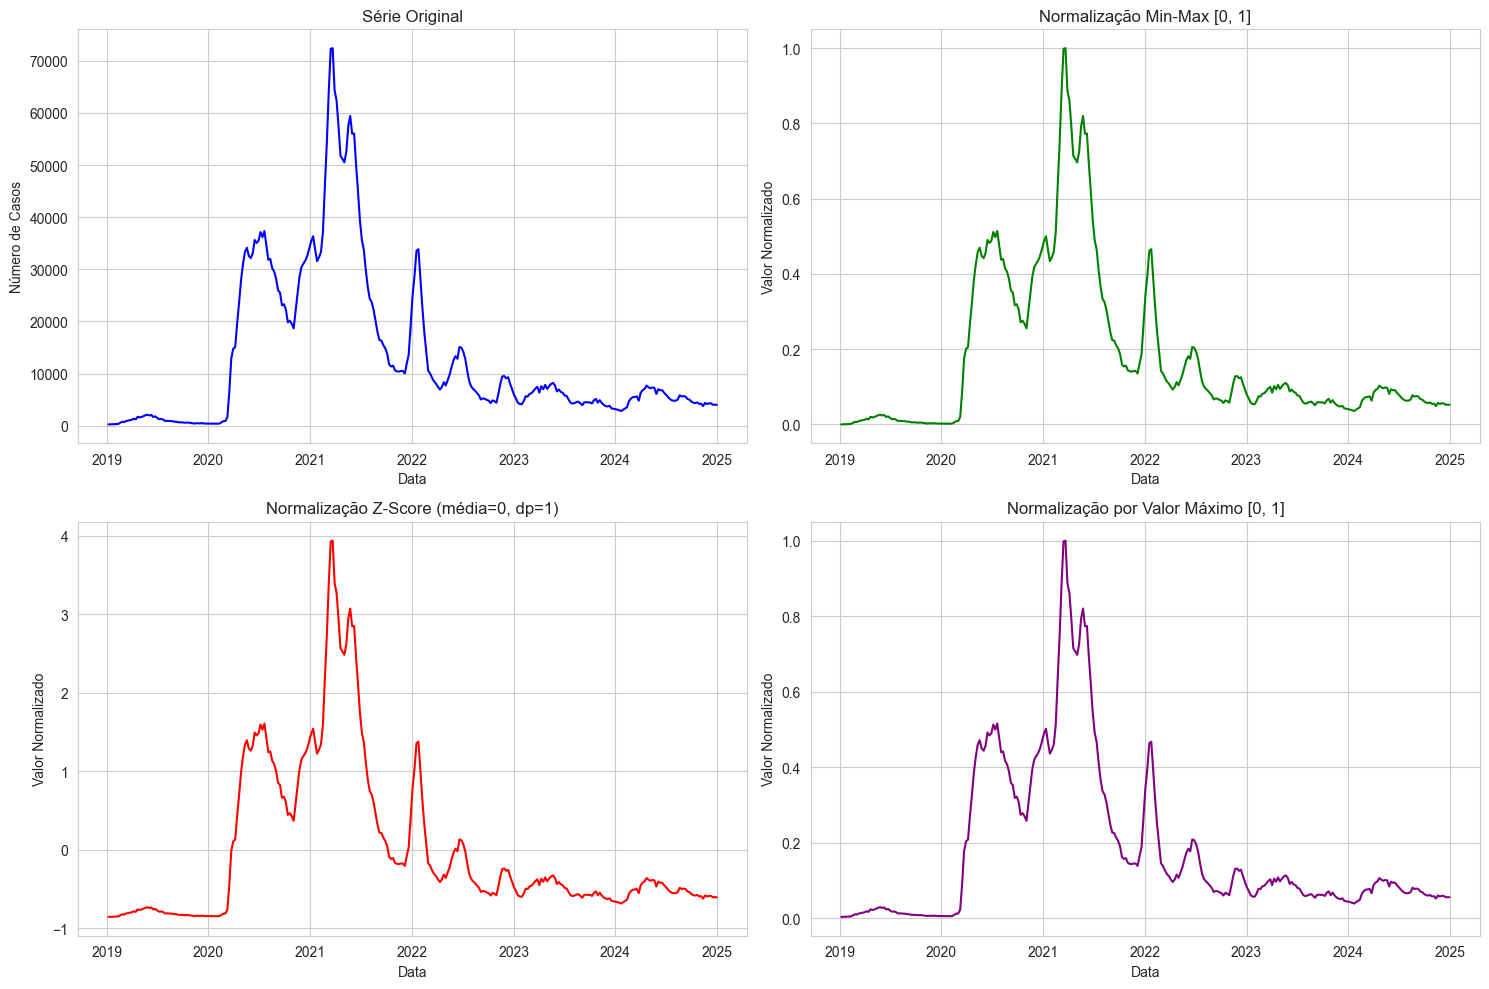

In [15]:
# Aplicar diferentes técnicas de normalização
df['MinMax_Normalized'] = (df['Number_Cases'] - df['Number_Cases'].min()) / (df['Number_Cases'].max() - df['Number_Cases'].min())
df['ZScore_Normalized'] = (df['Number_Cases'] - df['Number_Cases'].mean()) / df['Number_Cases'].std()
df['Max_Normalized'] = df['Number_Cases'] / df['Number_Cases'].max()

# Visualização comparativa
plt.figure(figsize=(15, 10))

# Série original
plt.subplot(2, 2, 1)
sns.lineplot(data=df, x='Year_Week', y='Number_Cases', color='blue')
plt.title('Série Original')
plt.xlabel('Data')
plt.ylabel('Número de Casos')
plt.grid(True)

# Min-Max Normalized
plt.subplot(2, 2, 2)
sns.lineplot(data=df, x='Year_Week', y='MinMax_Normalized', color='green')
plt.title('Normalização Min-Max [0, 1]')
plt.xlabel('Data')
plt.ylabel('Valor Normalizado')
plt.grid(True)

# Z-Score Normalized
plt.subplot(2, 2, 3)
sns.lineplot(data=df, x='Year_Week', y='ZScore_Normalized', color='red')
plt.title('Normalização Z-Score (média=0, dp=1)')
plt.xlabel('Data')
plt.ylabel('Valor Normalizado')
plt.grid(True)

# Max Normalized
plt.subplot(2, 2, 4)
sns.lineplot(data=df, x='Year_Week', y='Max_Normalized', color='purple')
plt.title('Normalização por Valor Máximo [0, 1]')
plt.xlabel('Data')
plt.ylabel('Valor Normalizado')
plt.grid(True)

plt.tight_layout()
plt.show()

### Rolling Average
A média contínua é simplesmente a média de uma janela de observações anteriores, em que a janela é uma sequência de valores dos dados da série temporal. A média é calculada para cada janela ordenada. Isso pode ajudar muito a minimizar o ruído nos dados de séries temporais.

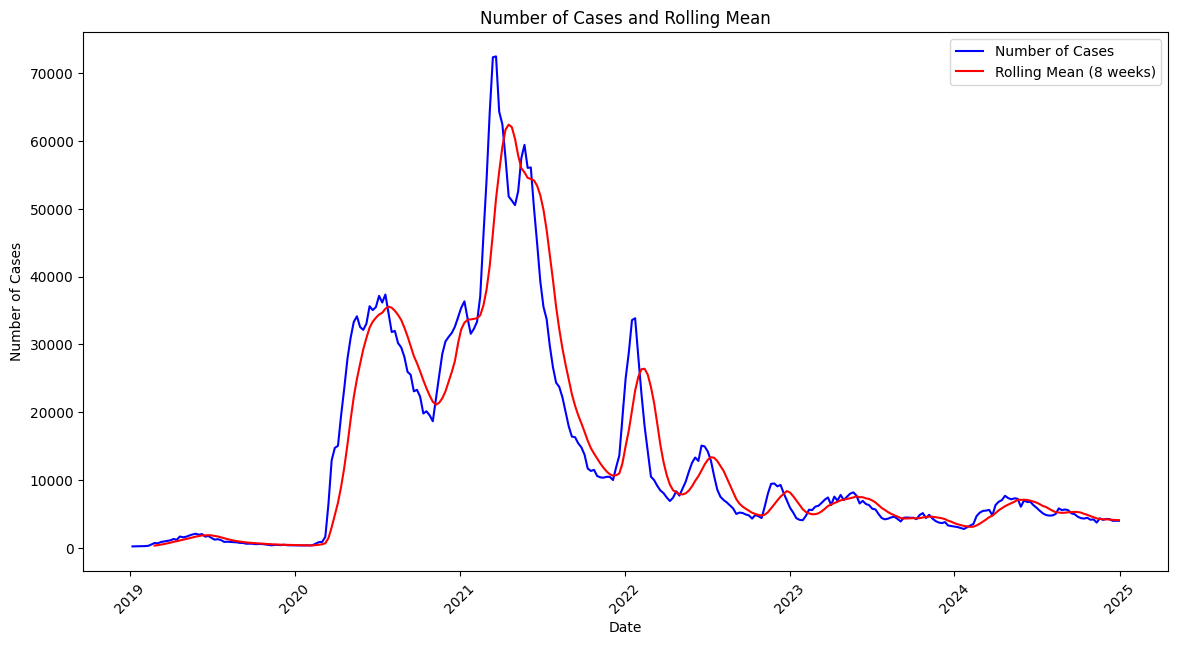

In [5]:
df["rolling_mean"] = df["Number_Cases"].rolling(8).mean()

plt.figure(figsize=(14, 7))

sns.lineplot(data=df, x='Year_Week', y='Number_Cases', label='Number of Cases', color='blue')
sns.lineplot(data=df, x='Year_Week', y='rolling_mean', label='Rolling Mean (8 weeks)', color='red')

# Melhorar o visual
plt.title('Number of Cases and Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

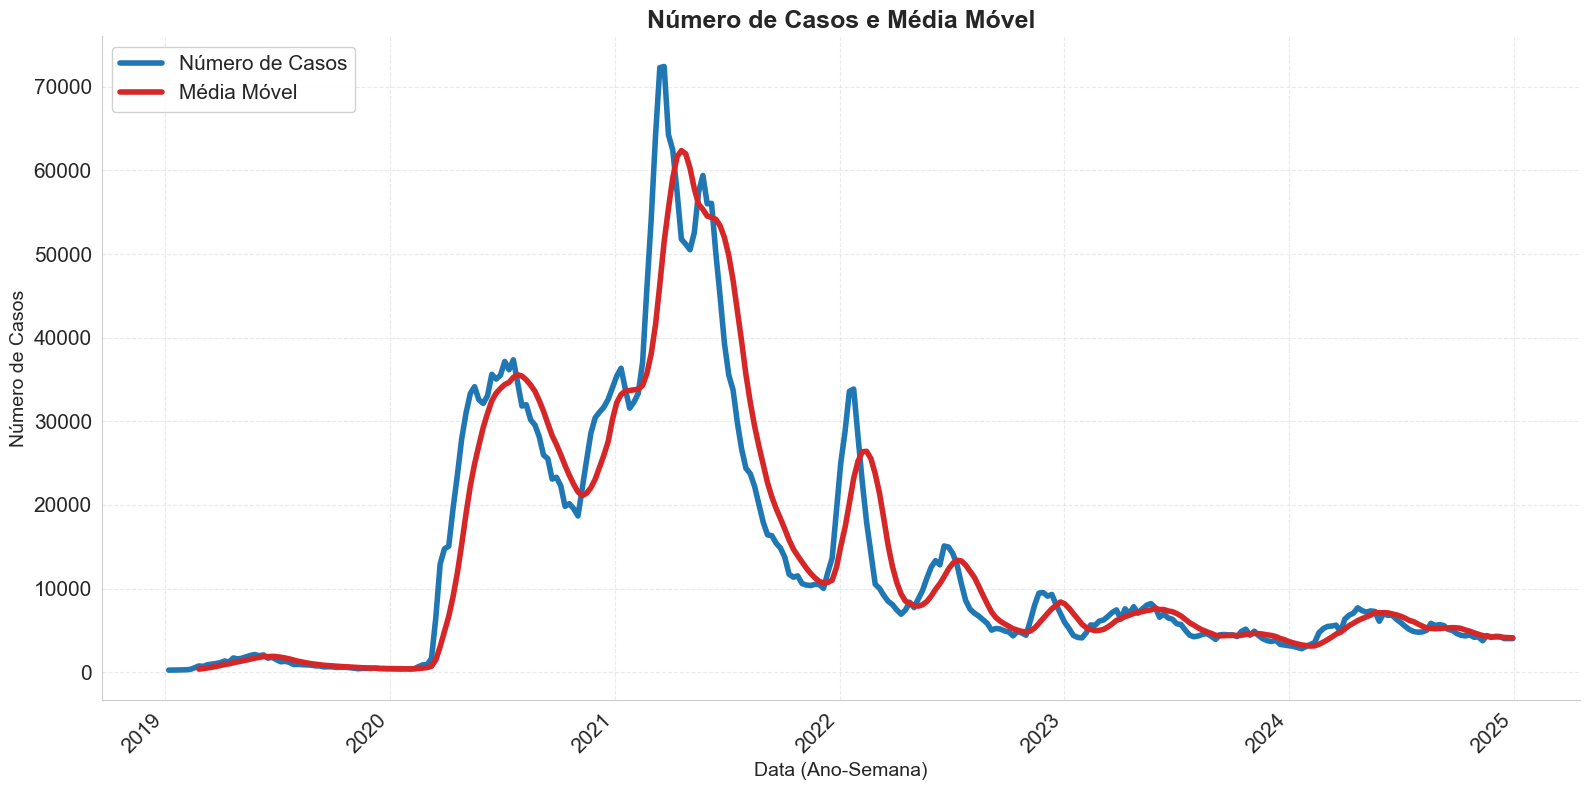

In [8]:
# Estilo moderno e limpo
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

# Paleta de cores suaves e espessura maior das linhas
sns.lineplot(data=df, x='Year_Week', y='Number_Cases', label='Número de Casos', color='#1f77b4', linewidth=4)
sns.lineplot(data=df, x='Year_Week', y='rolling_mean', label='Média Móvel', color='#d62728', linewidth=4)

# Título e rótulos com fontes maiores e mais legíveis
plt.title('Número de Casos e Média Móvel', fontsize=18, fontweight='bold')
plt.xlabel('Data (Ano-Semana)', fontsize=14)
plt.ylabel('Número de Casos', fontsize=14)

# Estilo da legenda
plt.legend(fontsize=15, loc='upper left', frameon=True, framealpha=0.9)

# Rodar os rótulos do eixo X e melhorar espaçamento
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)

# Adicionar uma leve grade
plt.grid(visible=True, linestyle='--', alpha=0.4)

# Bordas do gráfico mais suaves
sns.despine()

plt.tight_layout()
plt.show()

Podemos observar algumas limitações desse método:
- Temos uma perda dos dados iniciais
- A suavização possui um atraso na detecção de tendências (Dificil em reconhecer mudanças abruptas)

--

### Transformada de Fourier
Pode ajudar a remover o ruído convertendo os dados da série temporal no domínio da frequência e, a partir daí, podemos filtrar as frequências ruidosas. Em seguida, podemos aplicar a transformada inversa de Fourier para obter a série temporal filtrada.

In [16]:
fft_values = np.fft.fft(df['Number_Cases'])

#Obter as frequências associadas
frequencies = np.fft.fftfreq(len(fft_values))

# eliminar frequências maiores que um limiar
cutoff = 0.1
fft_values_filtered = fft_values.copy()
fft_values_filtered[np.abs(frequencies) > cutoff] = 0

# Aplicar a Transformada Inversa
filtered_signal = np.fft.ifft(fft_values_filtered)

# removendo imaginario
filtered_signal = np.real(filtered_signal)
df["denoised_fourier"] = filtered_signal
df

,Year_Week,Number_Cases,week,rolling_mean,denoised_fourier,Log_Number_Cases,MinMax_Normalized,ZScore_Normalized,Max_Normalized
0,2019-01-07,256.0,2,NaN,1551.630264,5.549076,0.000000,-0.853830,0.003535
1,2019-01-14,270.0,3,NaN,933.491341,5.602119,0.000194,-0.852900,0.003728
2,2019-01-21,273.0,4,NaN,511.046132,5.613128,0.000236,-0.852701,0.003769
3,2019-01-28,282.0,5,NaN,289.749631,5.645447,0.000360,-0.852103,0.003894
4,2019-02-04,300.0,6,NaN,236.634048,5.707110,0.000610,-0.850907,0.004142
...,...,...,...,...,...,...,...,...,...
312,2024-12-02,4298.0,49,4231.250,4726.112140,8.366138,0.056008,-0.585367,0.059345
313,2024-12-09,4284.0,50,4223.125,4422.393784,8.362876,0.055814,-0.586297,0.059152
314,2024-12-16,4028.0,51,4167.875,3862.848500,8.301273,0.052267,-0.603300,0.055617
315,2024-12-23,4028.0,52,4148.125,3122.487384,8.301273,0.052267,-0.603300,0.055617


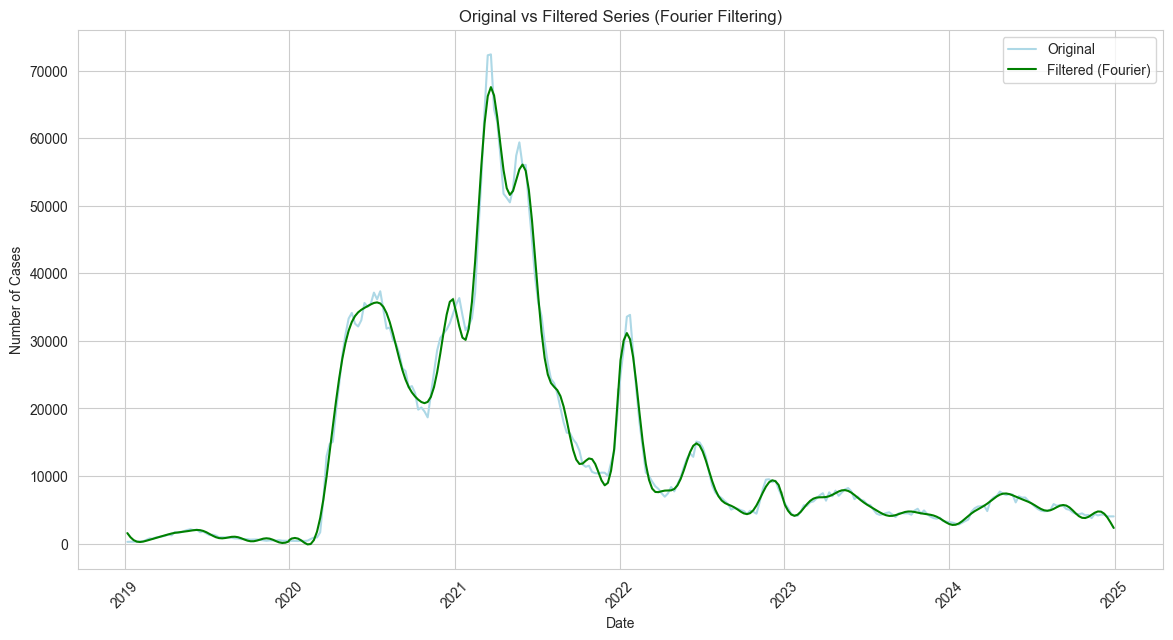

In [17]:
plt.figure(figsize=(14, 7))

sns.lineplot(data=df, x='Year_Week', y='Number_Cases', label='Original', color='lightblue')
sns.lineplot(data=df, x='Year_Week', y='denoised_fourier', label='Filtered (Fourier)', color='green')

plt.title('Original vs Filtered Series (Fourier Filtering)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

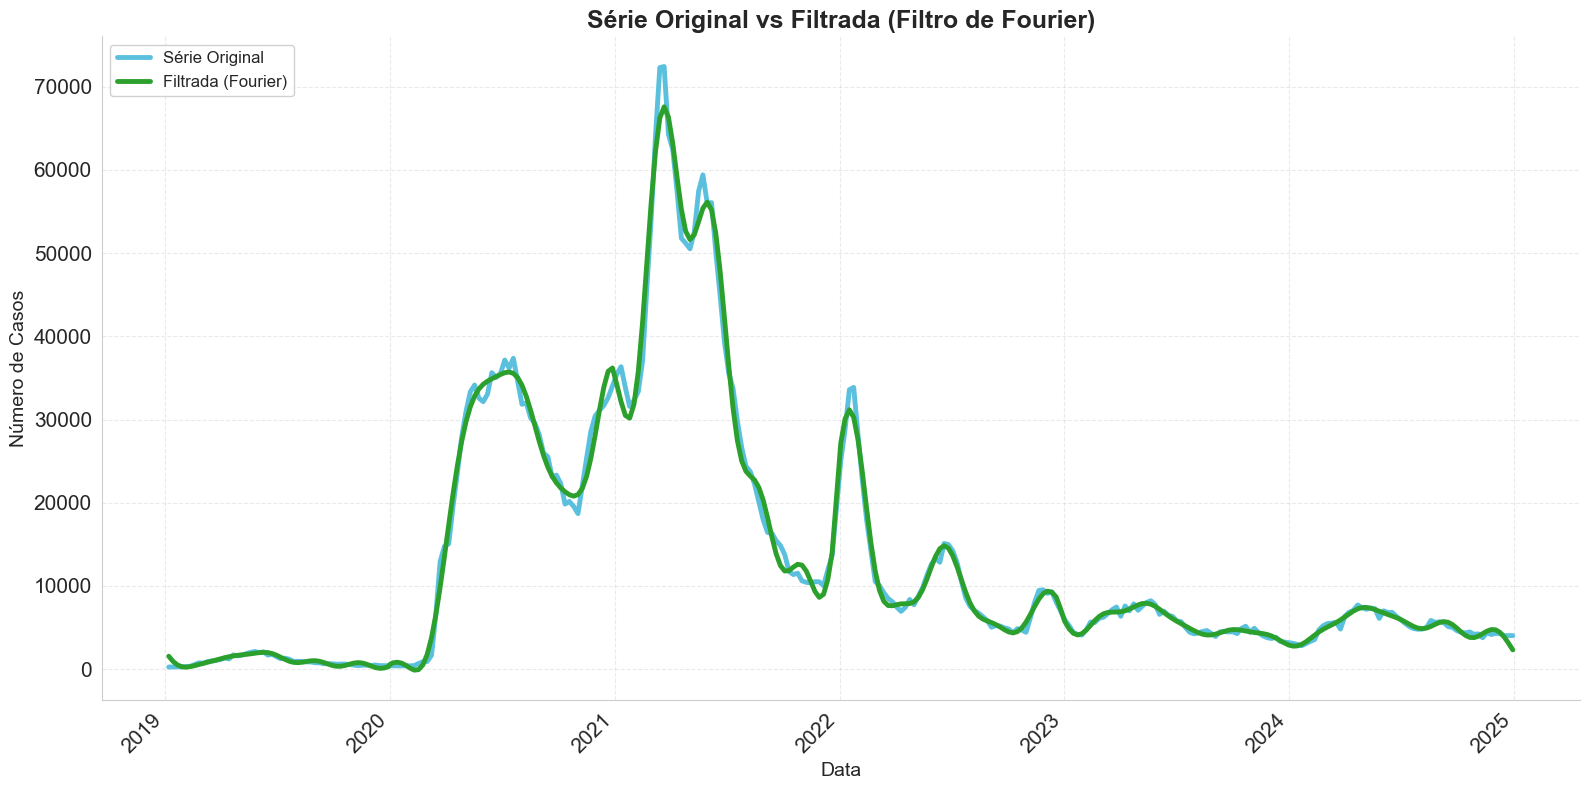

In [19]:
# Estilo do gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

# Linhas com cores modernas e espessura reforçada
sns.lineplot(data=df, x='Year_Week', y='Number_Cases', 
             label='Série Original', color='#5bc0de', linewidth=3.5)

sns.lineplot(data=df, x='Year_Week', y='denoised_fourier', 
             label='Filtrada (Fourier)', color='#2ca02c', linewidth=3.5)

# Título e rótulos com fonte maior e negrito
plt.title('Série Original vs Filtrada (Filtro de Fourier)', fontsize=18, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Número de Casos', fontsize=14)

# Legenda com estilo limpo
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9)

# Rótulos e ticks ajustados
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)

# Grade sutil
plt.grid(visible=True, linestyle='--', alpha=0.4)

# Remover bordas externas
sns.despine()

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

--

### Filtro Savitzky-Golay
O filtro de Savitzky-Golay é usado para suavizar séries temporais (remover ruído) sem distorcer muito as tendências — ele faz isso ajustando pequenos polinômios a janelas móveis do seu dado.


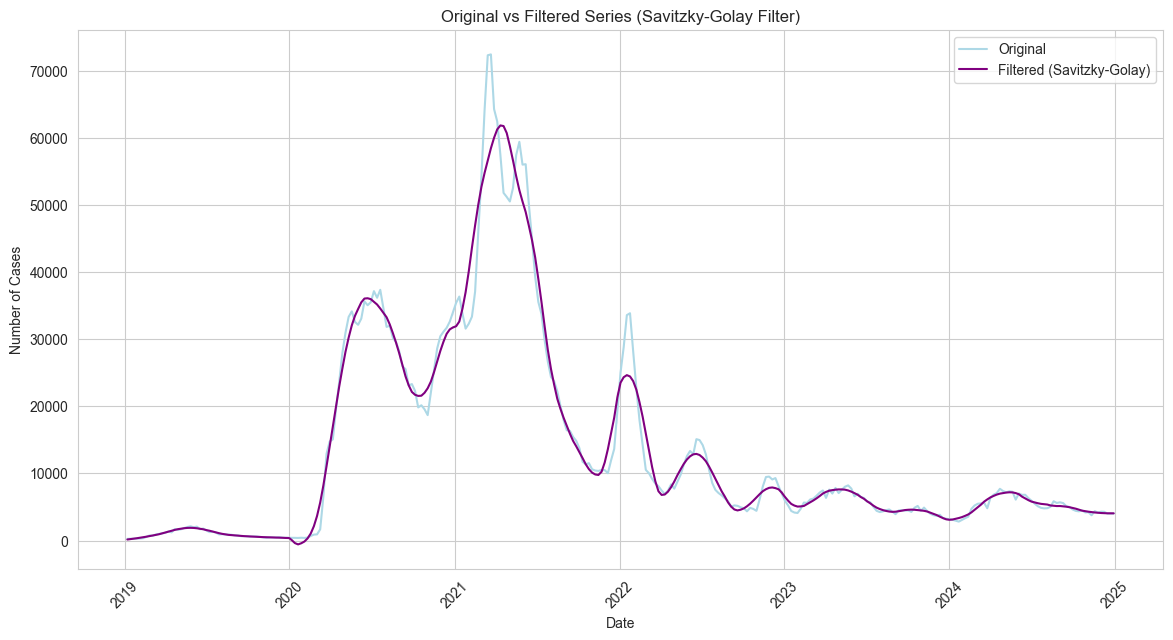

In [20]:
from scipy.signal import savgol_filter

df["denoised_savgol"] = savgol_filter(df["Number_Cases"], window_length=21, polyorder=2)

plt.figure(figsize=(14, 7))

sns.lineplot(data=df, x='Year_Week', y='Number_Cases', label='Original', color='lightblue')
sns.lineplot(data=df, x='Year_Week', y='denoised_savgol', label='Filtered (Savitzky-Golay)', color='purple')

plt.title('Original vs Filtered Series (Savitzky-Golay Filter)')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

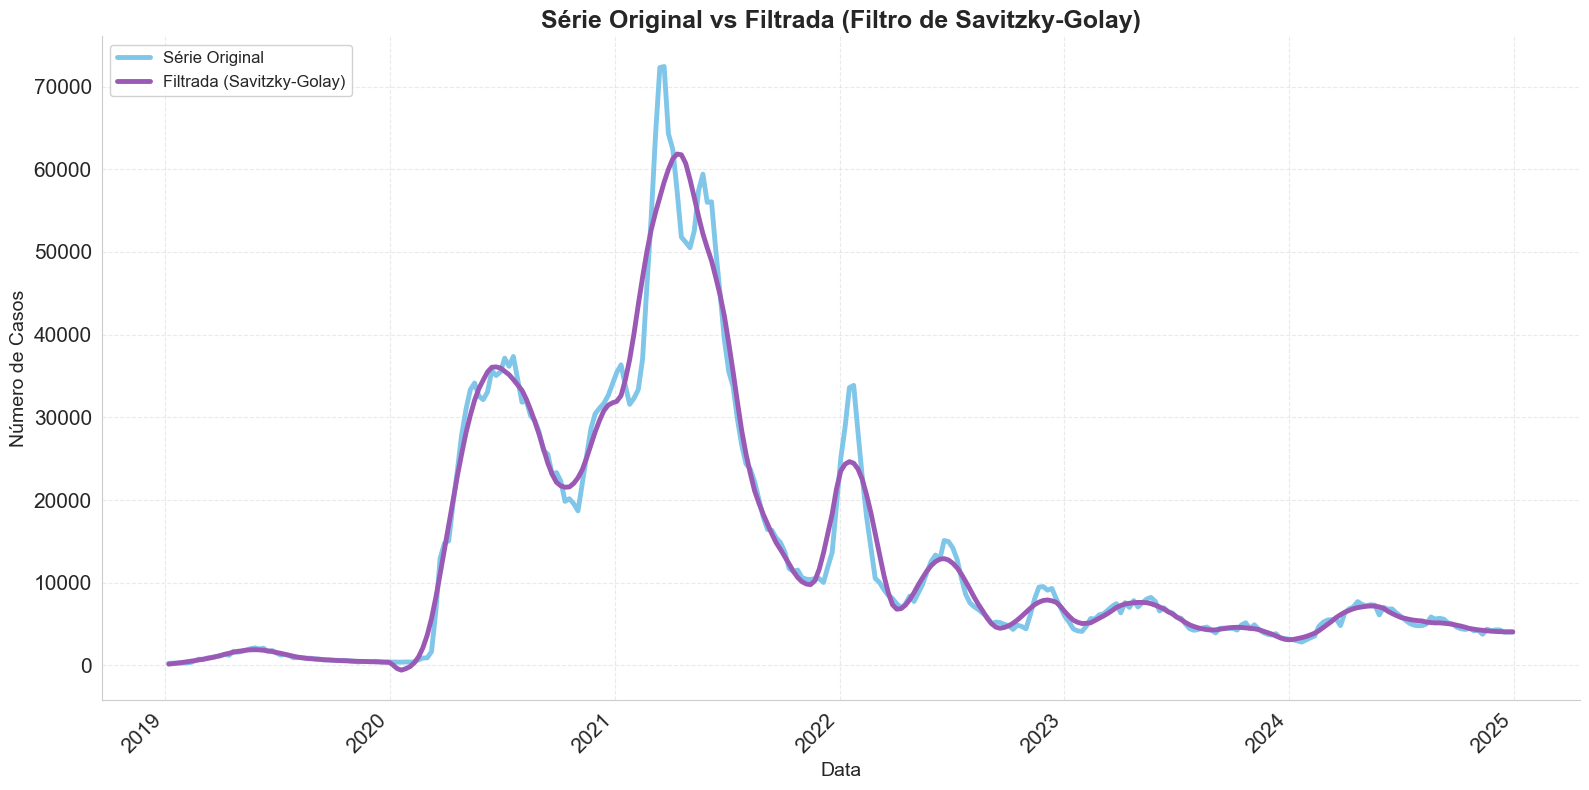

In [22]:
# Aplicar o filtro (caso ainda não tenha feito)
df["denoised_savgol"] = savgol_filter(df["Number_Cases"], window_length=21, polyorder=2)

# Estilo moderno
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

# Linhas com cores modernas e espessura reforçada
sns.lineplot(data=df, x='Year_Week', y='Number_Cases', 
             label='Série Original', color='#7fc6e8', linewidth=3.5)

sns.lineplot(data=df, x='Year_Week', y='denoised_savgol', 
             label='Filtrada (Savitzky-Golay)', color='#9b59b6', linewidth=3.5)

# Título e eixos
plt.title('Série Original vs Filtrada (Filtro de Savitzky-Golay)', fontsize=18, fontweight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Número de Casos', fontsize=14)

# Legenda com fundo sutil
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9)

# Eixo X rotacionado
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)

# Grade sutil
plt.grid(visible=True, linestyle='--', alpha=0.4)

# Remoção das bordas externas
sns.despine()

# Ajustar layout final
plt.tight_layout()
plt.show()